2D Poisson equation:
$$u_{xx} + u_{yy} = f(x, y)$$
where 
$$f(x, y) = -8\pi^2 \sin(2\pi x) \sin(2\pi y)$$

Over the domain $\Omega = [0, 1] \times [0, 1]$, with mixed boundary conditions:
$$u(x, 0) = 0$$
$$u(0, y) = u(1, y)$$
$$\frac{\partial u}{\partial n}(x, 1) = 2\pi \sin(2\pi x)$$

The solution we're aiming for is $$u(x, y) = \sin(2\pi x) \sin(2\pi y)$$.

In [15]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io
from scipy.stats import qmc

In [16]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def plot3D_Matrix(x, y, u):
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(x, y, u ,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u(x,y)')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()

  
  ax = plt.axes(projection='3d')
  ax.plot_surface(x.numpy(), y.numpy(), u.numpy(),cmap="rainbow")
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('u(x,y)')
  plt.show()

In [18]:
def f_real(x, y):
    return torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

In [19]:
steps = 20000
lr = 0.001
layers = np.array([2, 32, 32, 1])

x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x = 200
total_points_y = 200

N_boundary = 4 # number of boundaries
N_u_boundary = 100 # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = 10000 # number of collocation points

w_bc_top = 1
w_bc_bottom = 1
w_bc_lr = 1

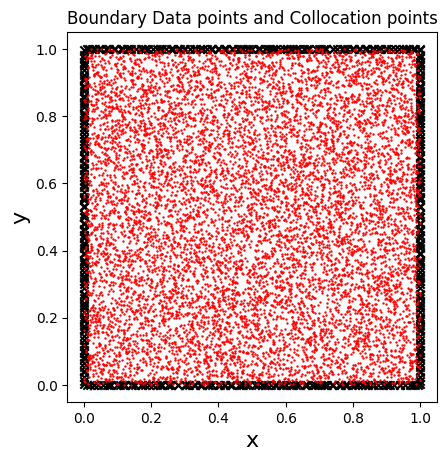

In [20]:
engine = qmc.LatinHypercube(d=1)

boundary_top = engine.random(n = N_u_boundary)
boundary_lr = engine.random(n = N_u_boundary)
boundary_bot = engine.random(n = N_u_boundary)

data = np.zeros([N_boundary, N_u_boundary, 2])

data[0, :, 0] = boundary_top[:, 0]
data[1, :, 1] = boundary_lr[:, 0]
data[2, :, 1] = boundary_lr[:, 0]
data[3, :, 0] = boundary_bot[:, 0]

data[0, :, 1] = np.ones(N_u_boundary) # y = 1
data[1, :, 0] = np.zeros(N_u_boundary) # x = 0
data[2, :, 0] = np.ones(N_u_boundary) # x = 1
data[3, :, 1] = np.zeros(N_u_boundary) # y = 0

data = data.reshape(-1, 2)
x_d, y_d = data[:, 0:1], data[:, 1:2]

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n = N_f)

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

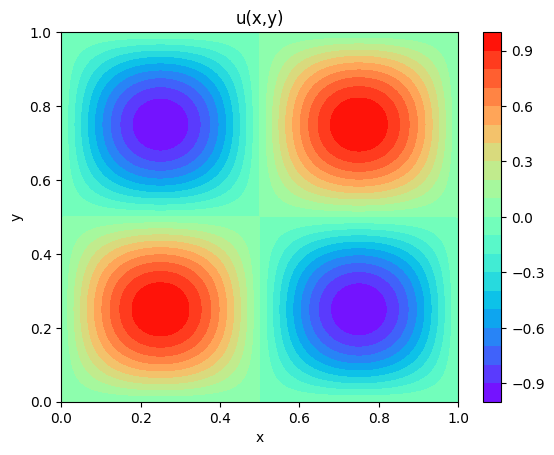

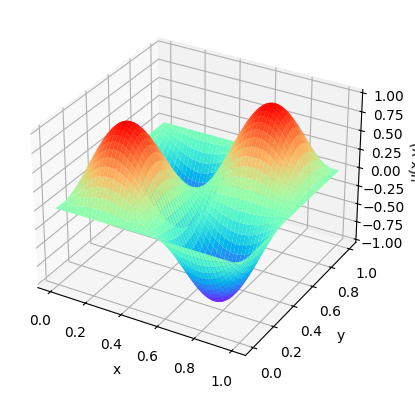

In [21]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)
U_real = f_real(X, Y)

plot3D_Matrix(X, Y, U_real)

In [22]:
# indexing nonsense - I don't know what this means

x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
u_test = U_real.transpose(1, 0).flatten()[:, None]

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

train_bd_top = torch.tensor(boundary_top).float().to(device)
train_bd_lr = torch.tensor(boundary_lr).float().to(device)
train_bd_bot = torch.tensor(boundary_bot).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)



In [23]:
class PINN(nn.Module):

    def __init__(self, layers):
        super().__init__()
        
        self.activation = nn.Sigmoid()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        
        a = torch.cat((x.float(), y.float()), axis=1)

        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    # Neumann BC on top
    def loss_BC_top(self, x):
        x_clone = x.clone().requires_grad_(True)
        y = torch.ones_like(x_clone).requires_grad_(True)
        
        u = self.forward(x_clone, y)
        u_y = autograd.grad(u.sum(), y, create_graph=True)[0]
        
        return self.loss_function(u_y, 2 * np.pi * torch.cos(2 * np.pi * x_clone))
    
    # Periodic BC on left/right
    def loss_BC_lr(self, y):
        u_l = self.forward(torch.zeros_like(y), y)
        u_r = self.forward(torch.ones_like(y), y)
        
        return self.loss_function(u_l, u_r)
    
    # Dirichlet BC on bottom
    def loss_BC_bot(self, x):
        return self.loss_function(self.forward(x, torch.zeros_like(x)), torch.zeros_like(x))
    
    def loss_PDE(self, x, y):
        x_clone = x.clone().requires_grad_(True)
        y_clone = y.clone().requires_grad_(True)
        
        u = self.forward(x_clone, y_clone)
        u_x = autograd.grad(u.sum(), x_clone, create_graph=True)[0]
        u_y = autograd.grad(u.sum(), y_clone, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x_clone, create_graph=True)[0]
        u_yy = autograd.grad(u_y.sum(), y_clone, create_graph=True)[0]

        f = u_xx + u_yy
        return self.loss_function(f + 8 * np.pi**2 * torch.sin(2 * np.pi * x_clone) * torch.sin(2 * np.pi * y_clone), torch.zeros_like(f))
    
    def loss (self, x_top, x_bot, y_lr, x_PDE, y_PDE):
        return w_bc_bottom * self.loss_BC_bot(x_bot) + w_bc_lr * self.loss_BC_lr(y_lr) + w_bc_top * self.loss_BC_top(x_top) + self.loss_PDE(x_PDE, y_PDE)

In [24]:
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
start_time = time.time()

train_losses = np.array([])
test_losses = np.array([])

for epoch in range(steps):
    optimizer.zero_grad()
    loss = model.loss(train_bd_top, train_bd_bot, train_bd_lr, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        with torch.no_grad():
            # Add testing collocation points to make this work better
            test_loss = model.loss_function(model(x_test[:, 0:1], x_test[:, 1:2]), f_real(x_test[:, 0:1], x_test[:, 1:2]))
        train_losses = np.append(train_losses, loss.item())
        test_losses = np.append(test_losses, test_loss.item())
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')
        
end_time = time.time()
print(f'Training time: {end_time - start_time}s')

Epoch 0, Loss 1578.4205322265625
Epoch 1000, Loss 663.8412475585938
Epoch 2000, Loss 77.4443130493164
Epoch 3000, Loss 22.195390701293945
Epoch 4000, Loss 8.526389122009277
Epoch 5000, Loss 3.6699466705322266
Epoch 6000, Loss 1.7896041870117188
Epoch 7000, Loss 0.8702232837677002
Epoch 8000, Loss 0.5511362552642822
Epoch 9000, Loss 0.4030144214630127
Epoch 10000, Loss 0.3196454644203186
Epoch 11000, Loss 0.2731602191925049
Epoch 12000, Loss 0.21842476725578308
Epoch 13000, Loss 0.19014301896095276
Epoch 14000, Loss 0.1655062437057495
Epoch 15000, Loss 0.1482556164264679
Epoch 16000, Loss 0.14613988995552063
Epoch 17000, Loss 0.13142554461956024
Epoch 18000, Loss 0.11482308059930801
Epoch 19000, Loss 0.10668136924505234
Training time: 505.03533267974854s


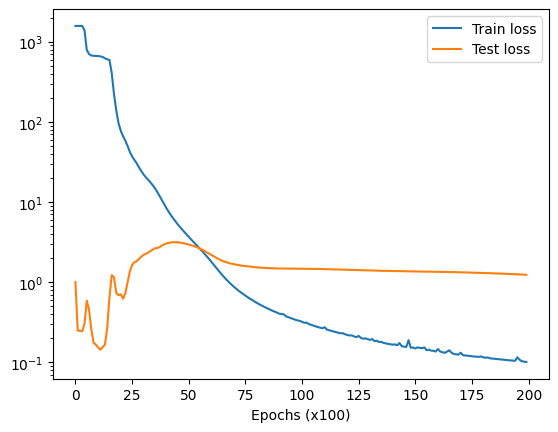

In [26]:
plt.semilogy(train_losses, label='Train loss')
plt.semilogy(test_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()


Plots!

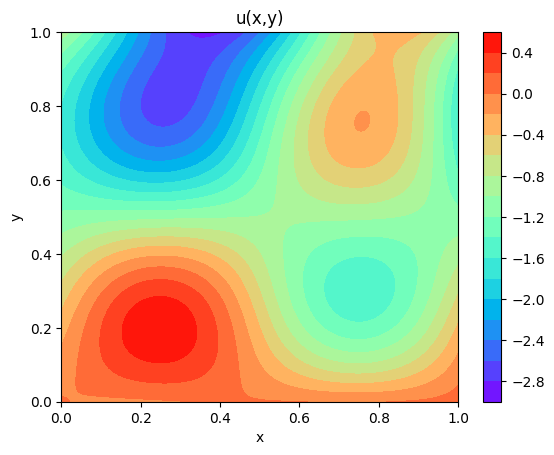

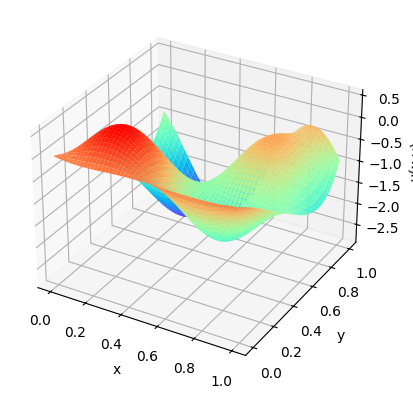

In [27]:
u_pred = model.forward(x_test[:, 0:1], x_test[:, 1:2]).cpu().detach()
u_pred = u_pred.reshape(total_points_x, total_points_y).transpose(1, 0)

# I think this transpose is correct? The shapes are weird
plot3D_Matrix(X, Y, u_pred)

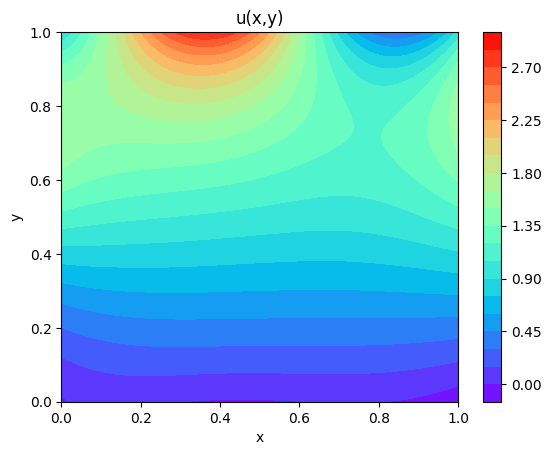

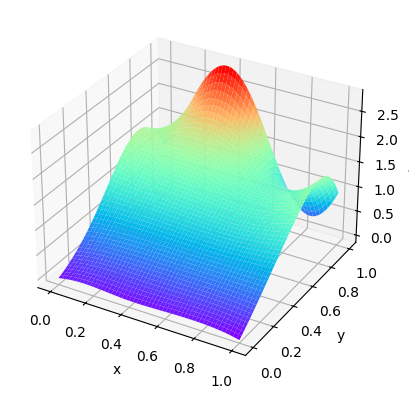

In [28]:
error = f_real(X, Y) - u_pred

plot3D_Matrix(X, Y, error)